In [1]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.6 MB/s eta 0:00:00


In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Total 463 (delta 0), reused 0 (delta 0), pack-reused 463 (from 1)
Receiving objects: 100% (463/463), 12.91 MiB | 13.46 MiB/s, done.
Resolving deltas: 100% (220/220), done.


In [4]:
%cd /content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
!sed -i 's/value.type()/value.scalar_type()/g' ms_deform_attn_cuda.cu
!sed -i 's/value.scalar_type().is_cuda()/value.is_cuda()/g' ms_deform_attn_cuda.cu

/content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn


In [5]:
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 86.8 MB/s eta 0:00:00


In [6]:
import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [7]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [8]:
import os

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


In [9]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/GroundingDINO


final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [239]:
from google.colab import files

# --- Upload image ---
uploaded = files.upload()
image_path = list(uploaded.keys())[0]   # take the first uploaded file

Saving download.jpeg to download (1).jpeg


In [240]:
TEXT_PROMPT = input("Enter your text prompt (e.g., 'a cat', 'a person', 'a car'): ")

Enter your text prompt (e.g., 'a cat', 'a person', 'a car'): dog


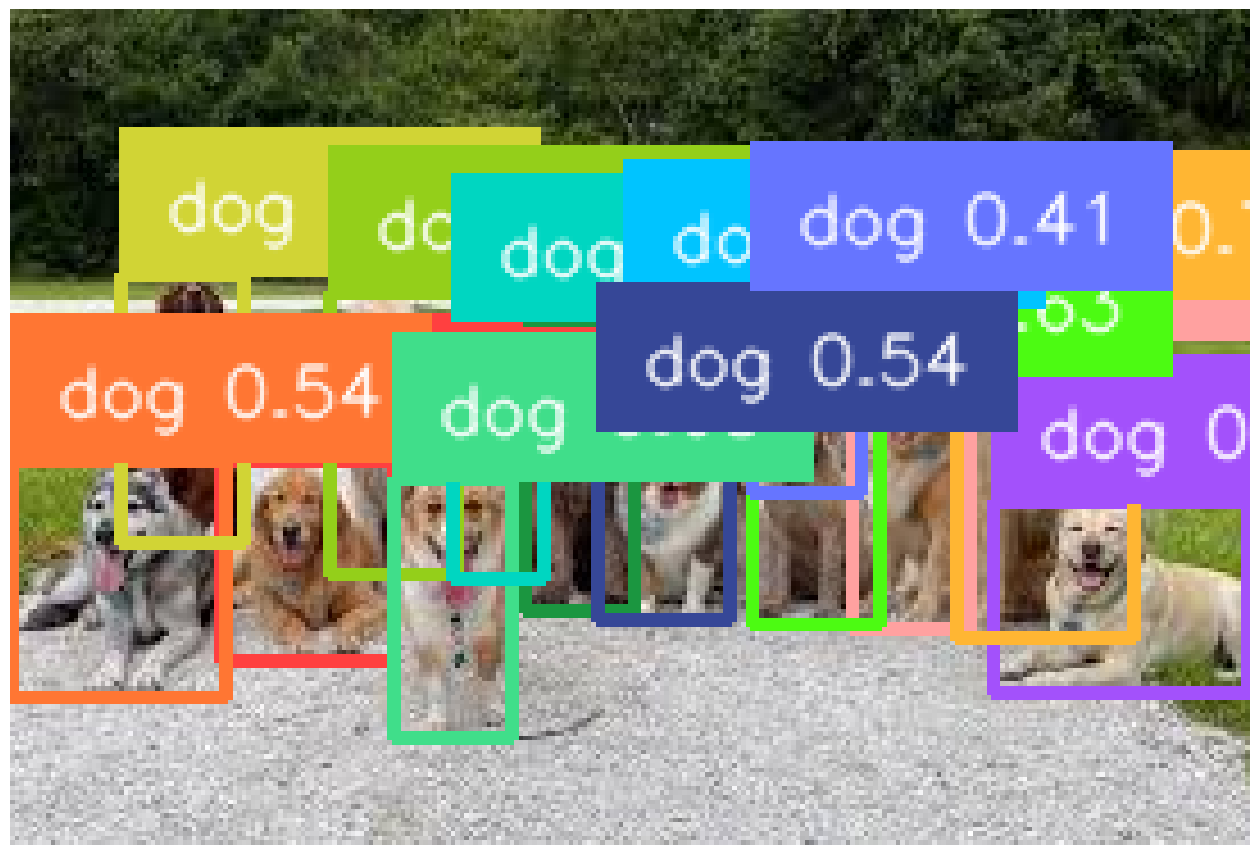

In [241]:
import supervision as sv

BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(image_path)


boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [242]:
print(boxes)
print(logits)
print(phrases)

tensor([[0.8963, 0.7061, 0.2060, 0.2283],
        [0.2391, 0.6604, 0.1373, 0.2349],
        [0.7275, 0.5676, 0.0951, 0.3501],
        [0.0877, 0.6810, 0.1741, 0.2812],
        [0.8354, 0.5488, 0.1435, 0.4094],
        [0.1395, 0.4793, 0.1015, 0.3215],
        [0.6493, 0.5864, 0.1021, 0.2949],
        [0.3097, 0.5086, 0.1041, 0.3335],
        [0.3587, 0.7173, 0.0953, 0.3124],
        [0.4602, 0.5489, 0.0891, 0.3429],
        [0.3934, 0.5287, 0.0738, 0.3115],
        [0.6297, 0.4004, 0.0609, 0.1343],
        [0.5415, 0.4458, 0.0896, 0.1791],
        [0.5261, 0.6170, 0.1071, 0.2258],
        [0.6422, 0.4555, 0.0862, 0.2429]])
tensor([0.7584, 0.7091, 0.6751, 0.5421, 0.6958, 0.6386, 0.6346, 0.6599, 0.6817,
        0.6251, 0.5900, 0.4787, 0.5705, 0.5354, 0.4133])
['dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog']


In [14]:
%cd ..

/content


In [15]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 15.35 MiB/s, done.
Resolving deltas: 100% (380/380), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.9 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


In [16]:
!mkdir -p {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [94]:
import torch
import base64
import matplotlib.pyplot as plt
import numpy as np
import supervision as sv
import cv2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [222]:
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [233]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)
sam2_model = sam2_model.to(DEVICE)
predictor = SAM2ImagePredictor(sam2_model)
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

In [243]:
image_bgr = cv2.imread(image_path)
H,W,_ = image_bgr.shape
print(image_bgr.shape)

(184, 273, 3)


In [244]:
xyxy_boxes = torch.zeros_like(boxes)
for i in range(boxes.shape[0]):
    x_c, y_c, w, h = boxes[i]
    x_c *= W
    y_c *= H
    w *= W
    h *= H
    x1 = x_c - w / 2
    y1 = y_c - h / 2
    x2 = x_c + w / 2
    y2 = y_c + h / 2

    xyxy_boxes[i] = torch.tensor([x1, y1, x2, y2])

In [245]:
print(xyxy_boxes)

tensor([[2.1658e+02, 1.0892e+02, 2.7282e+02, 1.5092e+02],
        [4.6520e+01, 9.9907e+01, 8.4013e+01, 1.4314e+02],
        [1.8564e+02, 7.2221e+01, 2.1159e+02, 1.3665e+02],
        [1.6703e-01, 9.9434e+01, 4.7703e+01, 1.5117e+02],
        [2.0847e+02, 6.3312e+01, 2.4765e+02, 1.3864e+02],
        [2.4236e+01, 5.8607e+01, 5.1953e+01, 1.1777e+02],
        [1.6333e+02, 8.0770e+01, 1.9121e+02, 1.3502e+02],
        [7.0335e+01, 6.2899e+01, 9.8750e+01, 1.2426e+02],
        [8.4918e+01, 1.0324e+02, 1.1094e+02, 1.6071e+02],
        [1.1346e+02, 6.9451e+01, 1.3779e+02, 1.3255e+02],
        [9.7337e+01, 6.8617e+01, 1.1747e+02, 1.2594e+02],
        [1.6361e+02, 6.1318e+01, 1.8022e+02, 8.6029e+01],
        [1.3560e+02, 6.5553e+01, 1.6006e+02, 9.8504e+01],
        [1.2901e+02, 9.2763e+01, 1.5826e+02, 1.3431e+02],
        [1.6355e+02, 6.1464e+01, 1.8709e+02, 1.0615e+02]])


In [246]:
predictor.set_image(image_source)

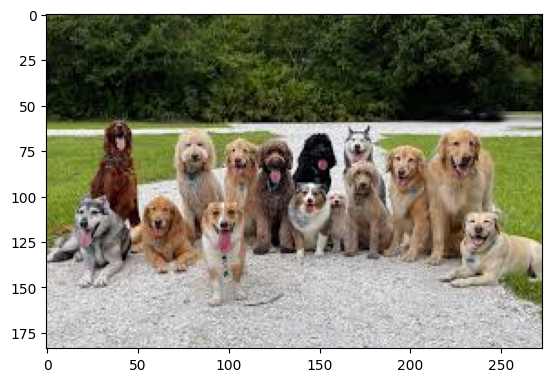

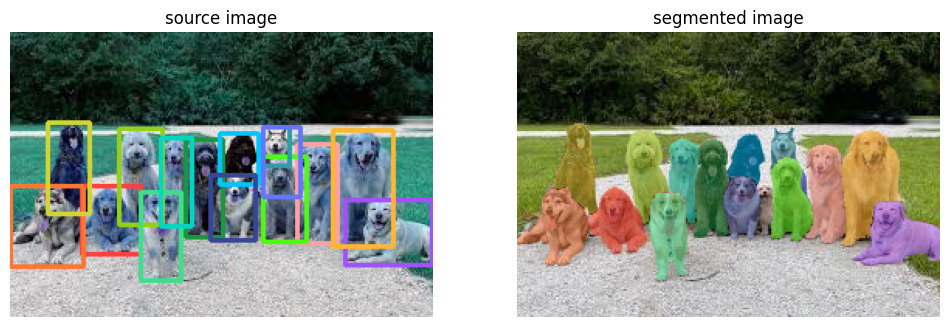

In [247]:
masks, scores, logits = predictor.predict(
    box=xyxy_boxes,
    multimask_output=False
)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
boxes_pixel = xyxy_boxes.cpu().numpy().astype(int)
if masks.ndim == 4 and masks.shape[1] == 1:
    masks_fixed = np.squeeze(masks, axis=1)
else:
    masks_fixed = masks  # already in correct shape

box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections(
    xyxy=boxes_pixel,
    mask=masks_fixed.astype(bool)
)
annotated_image = box_annotator.annotate(scene=image_source.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
sv.plot_images_grid(
    images=[annotated_image , segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)